# Risk and Portfolio Management

# Objective
The coding aims to statistically and fundamentally evaluate performance of 6 large-cap stocks from financial sector in Australia with market value between $10  billion to $200 billion, during Financial year 2022 - 2023. First objective is to filter the most notable stocks with highest changes during the period for further analysis. By looking at some key metrics of the stock:**returns, value at risk (VaR), volatility**, then estimate the expected returns of stock using simple financial model.

**Note**: Assuming ASX200 with top 200 largest companies represent the whole Australian financial market.

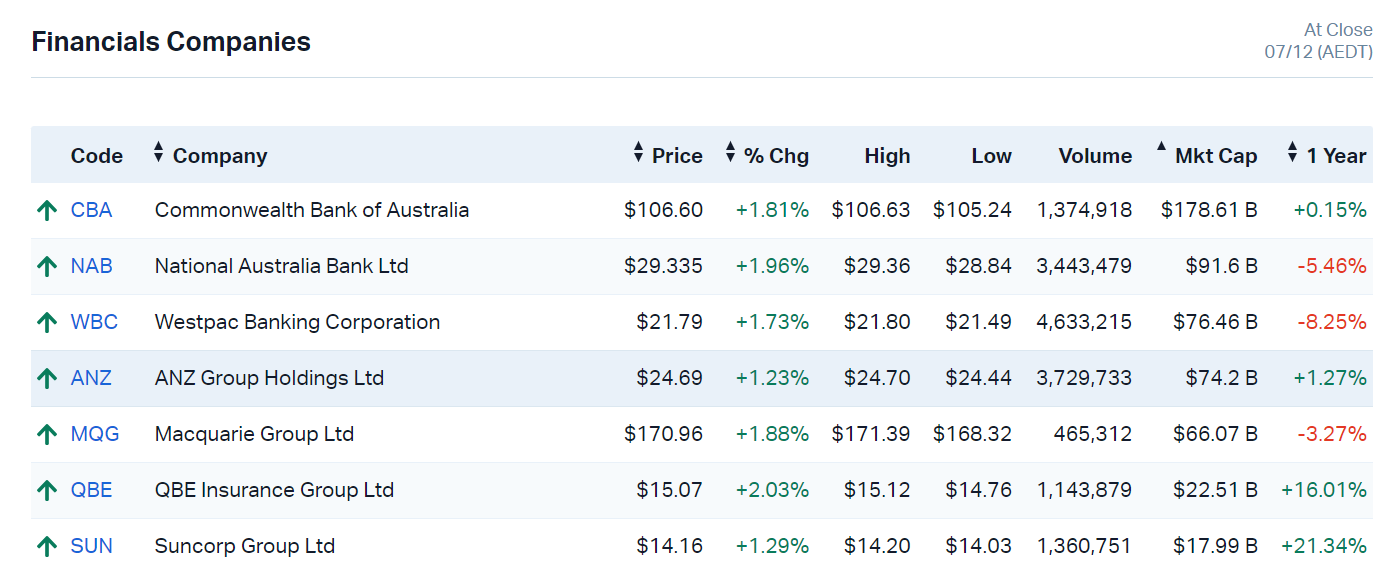

**Source**: Market Index (https://www.marketindex.com.au/asx/sectors/financials)

# Table of content
Part 1. Statistics
* Observation 1
* Observation 2

Part 2. Market Risk
* Observation 3

Part 3. Volatility
* Observation 4.1
* Observation 4.2
* Observation 4.3

Conclusion

Part 4. Expected Returns
* Decision for Portfolio Allocation
* Observation 5
<!-- * 5. Conclusion -->

# Definition
* (a) general market risk - the risk of loss owing to changes in the general level of market prices or interest rates. It    arises from positions in interest rate, equities, foreign exchange and commodities;
* (b) market risk - comprises general market risk and specific risk;
* (c) specific risk - the risk that the value of a security will change due to issuer-specific factors. It applies to interest rate and equity positions related to a specific issuer;
* (d) Beta (Risk Sensitivity): Beta measures the volatility of a stock relative to the market. A beta greater than 1 indicates higher volatility compared to the market, while a beta less than 1 suggests lower volatility.

# Preparation
Before starting the coding, there needs to have some package installment

In [1]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
import csv
from tabulate import tabulate

# Part 1: Statistics

This first step is to retrieve the data from a source, particularly Yahoo Finance for this report, then convert all values into daily relative percentage change in stock prices.The data will be rearranged, omitted dates with missing values, following by a generated descriptive summary and stocks' trendlines to have a better general market view.

In [2]:
stocks =['NAB.AX','WBC.AX','ANZ.AX','MQG.AX','QBE.AX','SUN.AX','^AXJO']
start_date = dt.datetime(2022, 10, 30)
end_date = dt.datetime(2023, 10, 30)
getData = yf.download(stocks, start=start_date, end=end_date) 
Data = getData['Close']    #Get the stock price
data = Data.pct_change()   #Convert into returns

returns = data.dropna()
returns = returns*100      #Get the relative % price changes
returns.head()

[*********************100%***********************]  7 of 7 completed


,ANZ.AX,MQG.AX,NAB.AX,QBE.AX,SUN.AX,WBC.AX,^AXJO
Date,,,,,,,
2022-11-01,1.564944,1.474926,0.863672,2.287587,2.103416,0.871004,1.652217
2022-11-02,0.077043,-1.813951,0.122327,0.638977,0.686695,0.740133,0.140468
2022-11-03,-1.154731,-1.438896,-1.802077,0.079359,0.682019,-2.408164,-1.843507
2022-11-04,-0.700936,2.355061,-0.093321,0.079304,-0.677399,0.961939,0.504529
2022-11-07,-4.588236,-1.273697,-1.214195,0.633914,-0.426251,-3.935372,0.597754


In [3]:
# summarize the data
print("Descriptive Statistics, in % changes")
returns.describe()

Descriptive Statistics, in % changes


,ANZ.AX,MQG.AX,NAB.AX,QBE.AX,SUN.AX,WBC.AX,^AXJO
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,-0.005277,-0.012617,-0.045897,0.097147,0.070088,-0.055100,0.000395
std,1.089255,1.329875,1.166039,1.382425,1.177520,1.113835,0.711771
min,-4.588236,-4.556570,-6.409807,-4.761904,-4.526743,-4.316851,-2.275990
25%,-0.543519,-0.764337,-0.620773,-0.700695,-0.646600,-0.557336,-0.438892
50%,0.121166,0.031516,0.069518,0.136522,0.143475,-0.044327,0.062329
75%,0.750869,0.812956,0.735418,0.930911,0.783679,0.670097,0.465094
max,2.694476,5.601043,2.461742,7.388065,4.570968,3.123630,2.785755


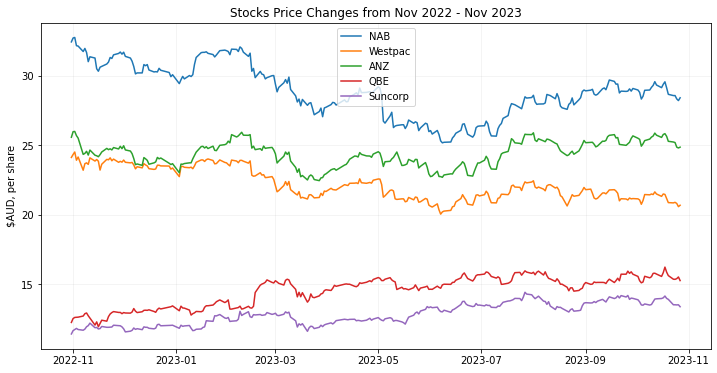

In [4]:
plt.figure(figsize=(12,6))
plt.plot(Data['NAB.AX'], label='NAB')
plt.plot(Data['WBC.AX'], label='Westpac')
plt.plot(Data['ANZ.AX'], label='ANZ')
plt.plot(Data['QBE.AX'], label='QBE')
plt.plot(Data['SUN.AX'], label='Suncorp')
plt.title('Stocks Price Changes from Nov 2022 - Nov 2023', fontsize=12)
plt.ylabel('$AUD, per share')
plt.grid(True, color='grey', alpha=0.1)
plt.legend()
plt.show()

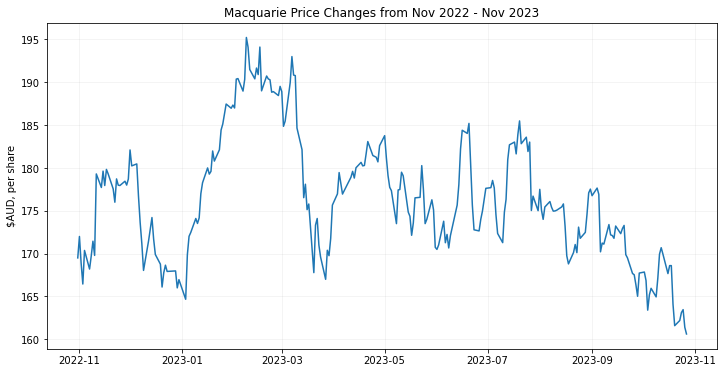

In [5]:
plt.figure(figsize=(12,6))
plt.plot(Data['MQG.AX'], label='Macquarie')
plt.title('Macquarie Price Changes from Nov 2022 - Nov 2023', fontsize=12)
plt.ylabel('$AUD, per share')
plt.grid(True, color='grey', alpha=0.1)
plt.show()

In [6]:
def stock_change():
    for x in stocks:
        w=returns[x].std()
        y=(Data[x][251]-Data[x][0])/Data[x][0]*100
        z=(max(Data[x])-min(Data[x]))/min(Data[x])*100
        desc[x]=[x,round(y,3),round(z,3),round(w,3)]
        
desc=pd.DataFrame(data={'':['','Changes after 1 year,%','Max/Min Range,%','Std of changes,%']},index=None)
stock_change()
print(tabulate(desc, headers='firstrow', tablefmt='fancy_grid'))

╒═════╤════════════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   0 │                        │   NAB.AX │   WBC.AX │   ANZ.AX │   MQG.AX │   QBE.AX │   SUN.AX │   ^AXJO │
╞═════╪════════════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│   1 │ Changes after 1 year,% │  -12.4   │  -14.268 │   -2.778 │   -5.239 │   24.592 │   17.178 │  -0.533 │
├─────┼────────────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────┤
│   2 │ Max/Min Range,%        │   30.127 │   22.317 │   15.775 │   21.548 │   35.96  │   26.293 │  10.948 │
├─────┼────────────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────┤
│   3 │ Std of changes,%       │    1.166 │    1.114 │    1.089 │    1.33  │    1.382 │    1.178 │   0.712 │
╘═════╧════════════════════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


### Observation 1
* Out of the 6, only QBE and SUN yield positive increase in price stock and also have greatest % changes (24.592% and 17.178%, respectively).
* MQG and QBE have the highest standard deviation value, relatively 1.33% and 1.382%.
* Despite its lower standard deviation of 1.166%, NAB has drastic contrast between lowest bound and highest bound in stock price, as shown in the chart. QBE still have the largest price gap of 35.96%.
* Hence, NAB.AX, QBE.AX and SUN.AX will be selected for further analysis.

In [7]:
returns.drop(columns=['ANZ.AX','MQG.AX','WBC.AX'], inplace=True)

## Financial highlights

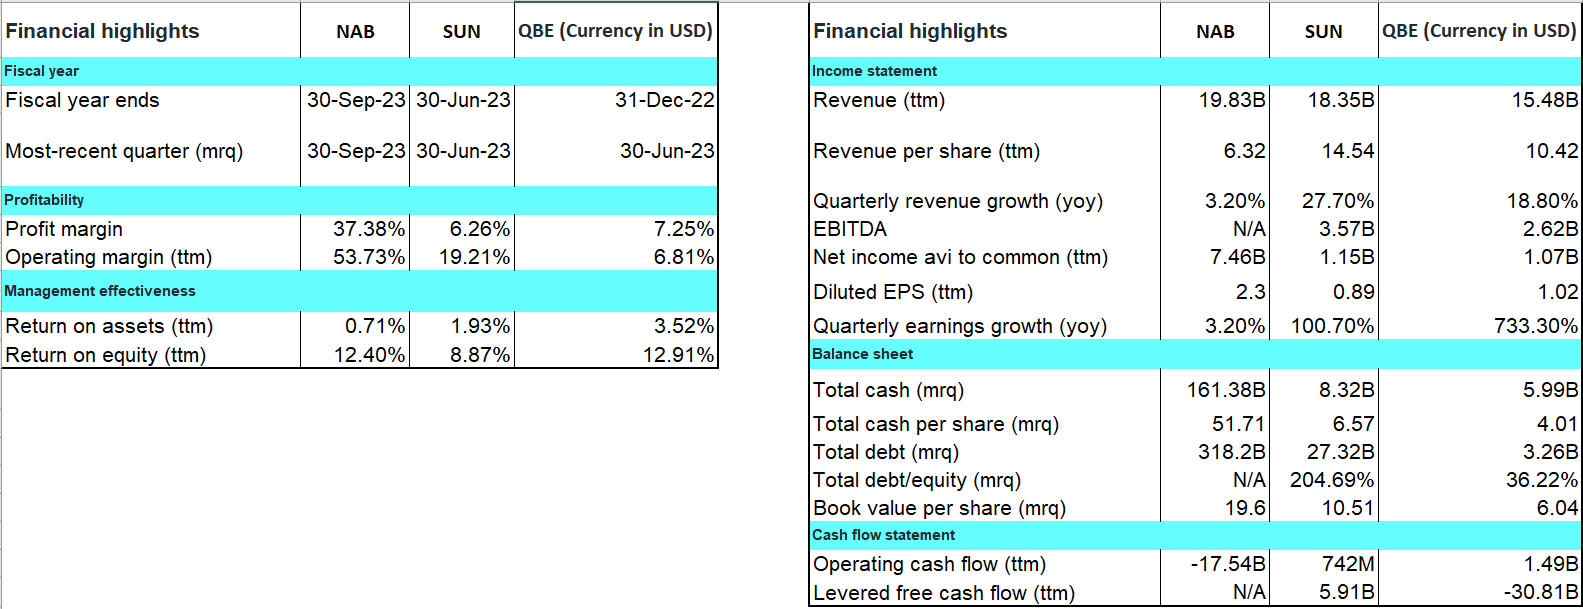

## Observation 2
Based on these figures, NAB demonstrates the highest profitability margins and operating efficiency among the three. SUN shows strong revenue growth but has a low current ratio, indicating potential liquidity concerns. QBE has a solid current ratio and respectable profitability metrics yet a drastic quarterly earnings growth year-on-year, making it a more balanced but stronger growing option.

# Part 2: Market Risk

This part intends to incorporate the internal model approach focusing around VaR (Value at Risk) from Prudential Standard APS-116: Capital Adequacy.

**VaR**: which is the maximum amount of loss that an investor is willing to bear with a given level of confidence.

In [9]:
work_day=252
split_date = returns.iloc[-work_day:].index

dtf = pd.DataFrame(data={'':['','10-day trading period VaR','Expected Shortfall']
                  })
for i in ('NAB.AX','QBE.AX','SUN.AX'):
     VaR_stock = returns[i].quantile(0.01)
     stock = returns[i]
     dtf[i]=[i, round(VaR_stock*(10**0.5),4), (stock[stock<VaR_stock].mean())*(10**0.5)]
print(tabulate(dtf, headers='firstrow', tablefmt='fancy_grid'))

╒═════╤═══════════════════════════╤══════════╤══════════╤══════════╕
│   0 │                           │   NAB.AX │   QBE.AX │   SUN.AX │
╞═════╪═══════════════════════════╪══════════╪══════════╪══════════╡
│   1 │ 10-day trading period VaR │ -11.0649 │ -12.1394 │  -8.8216 │
├─────┼───────────────────────────┼──────────┼──────────┼──────────┤
│   2 │ Expected Shortfall        │ -15.3296 │ -14.2036 │ -11.5668 │
╘═════╧═══════════════════════════╧══════════╧══════════╧══════════╛


## Observation 3
* NAB.AX: There is 99% chance that the maximum loss for holding NAB.AX over the next 10 trading days will not exceed 11.0649% per unit invested. If losses exceed the VaR, the average loss over those days would be approximately 15.3296% per unit invested. 
* QBE.AX: There is 99% chance that the maximum loss for holding NAB.AX over the next 10 trading days will not exceed 12.1394% per unit invested. If losses exceed the VaR, the average loss over those days would be approximately 14.2036% per unit invested.
* SUN.AX: There is 99% chance that the maximum loss for holding SUN.AX over the next 10 trading days will not exceed 8.8216% per unit invested. If losses exceed the VaR, the average loss over those days would be approximately 11.5668% per unit invested.

# Part 3: Volatility

**realized volatility**: measures the level of price fluctuation associated with a stock.

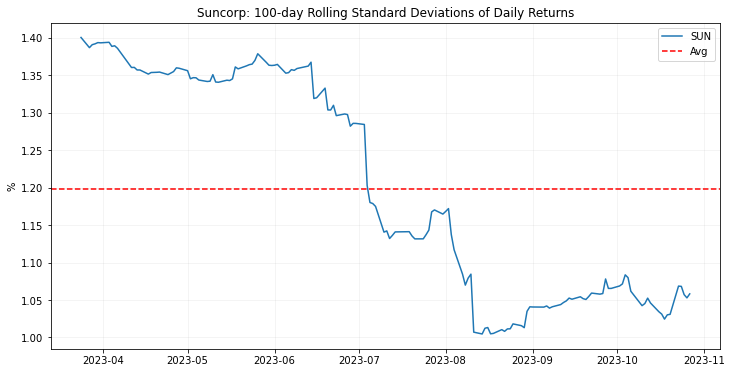

In [10]:
SUN_vol = returns['SUN.AX'].rolling(100).std()
sun_mean = SUN_vol.mean()

plt.figure(figsize=(12, 6))
plt.plot(SUN_vol, label='SUN')
plt.title('Suncorp: 100-day Rolling Standard Deviations of Daily Returns')
plt.ylabel('%')
plt.grid(True, color='grey', alpha=0.1)
plt.axhline(y=sun_mean, color='r', linestyle='--', label='Avg')

plt.legend()
plt.show()

## Observation 4.1
Throughout the observed timeframe, SUN's volatility levels frequently surpass the average market volatility of approximately 0.7%. This suggests that SUN experiences higher-than-average price fluctuations compared to the broader market. For the first half of the year, SUN experiences increased price fluctuations, potentially indicating significant market events or company-specific developments. The recent uptick in volatility towards the end of the observed period suggests evolving market dynamics or impending factors influencing SUN's performance.

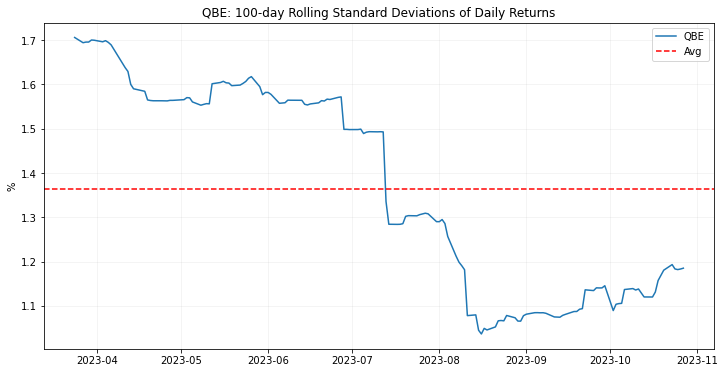

In [11]:
QBE_vol = returns['QBE.AX'].rolling(100).std()
qbe_mean = QBE_vol.mean()

plt.figure(figsize=(12, 6))
plt.plot(QBE_vol, label='QBE')
plt.axhline(y=qbe_mean, color='r', linestyle='--', label='Avg')
plt.title('QBE: 100-day Rolling Standard Deviations of Daily Returns')
plt.ylabel('%')
plt.grid(True, color='grey', alpha=0.1)

plt.legend()
plt.show()

## Observation 4.2
QBE shares a comparable trend with SUN in terms of volatility dynamics, albeit with distinct differences in average volatility levels. While both stocks exhibit similar patterns of price fluctuations over time, QBE stands out for its consistently higher average volatility, measuring at 1.364% compared to SUN's 1.198%. This discrepancy underscores the unique risk profiles of the two stocks, with QBE demonstrating a propensity for more pronounced price swings relative to SUN.

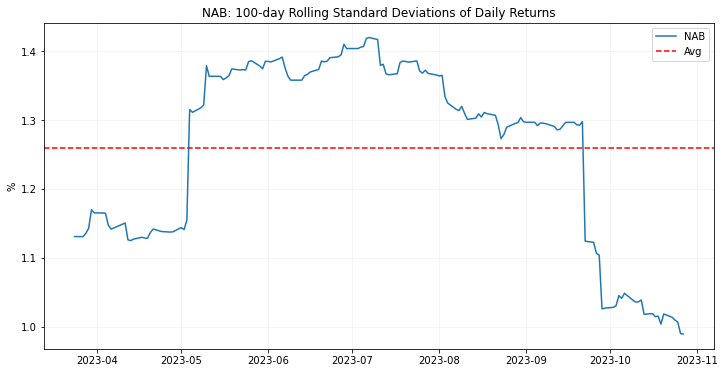

In [12]:
NAB_vol = returns['NAB.AX'].rolling(100).std()
nab_mean = NAB_vol.mean()

plt.figure(figsize=(12, 6))
plt.plot(NAB_vol, label='NAB')
plt.title('NAB: 100-day Rolling Standard Deviations of Daily Returns')
plt.ylabel('%')
plt.grid(True, color='grey', alpha=0.1)
plt.axhline(y=nab_mean, color='r', linestyle='--', label='Avg')

plt.legend()
plt.show()

## Observation 4.3
While both SUN and QBE exhibit high volatility primarily in the first half of the observed period, NAB bucks this trend by showcasing elevated volatility levels during the middle period. Moreover, in relation to the market average volatility of approximately 0.7%, all three stocks demonstrate higher-than-average volatility levels. However, NAB's volatility, although fluctuating throughout the period, tends to hover around its own elevated average volatility, emphasizing its unique risk profile within the market landscape.

# Conclusion

NAB demonstrates strong profitability margins and operating efficiency, while SUN exhibits robust revenue growth albeit with potential liquidity concerns. QBE, on the other hand, boasts a solid current ratio and respectable profitability metrics, positioning it as a balanced option with strong growth potential. Additionally, the analysis of maximum loss and Value at Risk (VaR) for each stock over the next 10 trading days indicates varying levels of risk, with SUN having the lowest maximum loss but potentially higher average losses if losses exceed the VaR.

# Part 4: Expected Return

## Decision for Portfolio Allocation
The distribution of assets in the portfolio follows a ratio of 50% to the best-performing stock, 30% to the second choice, and 20% to the third. The allocation is structured in this manner to favor opportunities (which is high surge of volatility) over safer options. The third stock, receiving the smallest allocation, typically exhibits characteristics such as underperformance, low volatility suggesting fewer investment prospects, sluggish growth, or a high level of debt.

Following a comprehensive analysis of the provided criteria, the ranking of the selected stocks is as follows:
* National Australia Bank Limited (NAB) 50%
* QBE Insurance Group Limited (QBE)     30%
* Suncorp Group Limited (SUN)           20%

In [23]:
cov = returns.cov()
var = returns['^AXJO'].var() 
risk_free_rate = 3.781
market_return = returns['^AXJO'].mean()
weights = {'NAB.AX': 0.5, 'QBE.AX': 0.3, 'SUN.AX': 0.2}


df = pd.DataFrame(data={'':['','Beta', 'Expected_returns, %','Weighted expected returns, %']
                  })
for i in ('NAB.AX','QBE.AX','SUN.AX'):
     beta = cov.loc['^AXJO',i]/var
     expected_return = risk_free_rate + beta*(market_return - risk_free_rate)
     weighted_expected_return = expected_return * weights[i]
     df[i]=[i, beta, expected_return, weighted_expected_return]
print(tabulate(df, headers='firstrow', tablefmt='fancy_grid'))
print("Total expected returns of portfolio: ",round(weighted_expected_return.sum(),4),"%")

╒═════╤══════════════════════════════╤═══════════╤══════════╤══════════╕
│   0 │                              │    NAB.AX │   QBE.AX │   SUN.AX │
╞═════╪══════════════════════════════╪═══════════╪══════════╪══════════╡
│   1 │ Beta                         │  1.05476  │ 0.73468  │ 0.847488 │
├─────┼──────────────────────────────┼───────────┼──────────┼──────────┤
│   2 │ Expected_returns, %          │ -0.206632 │ 1.00346  │ 0.576983 │
├─────┼──────────────────────────────┼───────────┼──────────┼──────────┤
│   3 │ Weighted expected returns, % │ -0.103316 │ 0.301039 │ 0.115397 │
╘═════╧══════════════════════════════╧═══════════╧══════════╧══════════╛
Total expected returns of portfolio:  0.1154 %


## Observation 5
Here, NAB.AX has a beta of 1.05476, indicating it's slightly more volatile than the market. QBE.AX has a beta of 0.73468, indicating lower volatility, and SUN.AX has a beta of 0.847488, also lower but slightly higher than QBE.AX. From the model, the portfolio is expected to experience a gain of 0.1154%, compared to 0.0004% of the market average return.